In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
import openpyxl
import pandas as pd
from utils.hmatr import Hmatr

%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

utils.install_packages('Rssa')

rssa = importr('Rssa')

D:\Program Files\anaconda\envs\researchWork\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Инициализация

In [2]:
N = 700
w1 = 1/10
w2 = 1/5
C1 = 1
C2 = 2
phi1 = 0
phi2 = np.pi/2
Q = 301  # 301 номер, значит разладка в ряде будет на 302й точке, если ряд задан с 0.
B = 100
T_ = 100
L = 50
r = 2
noiseVariance = 0.5

method = "svd"

In [3]:
def plotSeries(s, title='Series', w=16, h=4):
    plt.figure(figsize=(w, h))
    plt.title(title)
    plt.plot(s)

## Данные

Генерируем данные с фиксированным шумом и без.

In [4]:
seriesPermanent = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w2*n + phi1)
seriesTemporary = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C2*np.sin(2*np.pi*w1*n + phi1)
seriesShifted = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w1*n + phi2)
seriesOutlier = lambda n: C1*np.sin(2*np.pi*w1*n + phi1)

np.random.seed(0)
eps = np.random.randn(N) * noiseVariance**2

fPerm = [seriesPermanent(i) for i in range(N)]
fPermNoise = fPerm + eps
hmPerm = Hmatr(fPerm, B, T_, L, neig=r, svdMethod=method)
hmPermNoise = Hmatr(fPermNoise, B, T_, L, neig=r, svdMethod=method)

fTemp = [seriesTemporary(i) for i in range(N)]
tmp = deepcopy(eps)
tmp[:Q] = tmp[:Q]/2
fTempNoise = fTemp + tmp
hmTemp = Hmatr(fTemp, B, T_, L, neig=r, svdMethod=method)
hmTempNoise = Hmatr(fTempNoise, B, T_, L, neig=r, svdMethod=method)

fShifted = [seriesShifted(i) for i in range(N)]
fShiftedNoise = fShifted + eps
hmShifted = Hmatr(fShifted, B, T_, L, neig=r, svdMethod=method)
hmShiftedNoise = Hmatr(fShiftedNoise, B, T_, L, neig=r, svdMethod=method)


fOutlier = [seriesOutlier(i) for i in range(N)]
fOutlier[Q] = fOutlier[Q] + C1*10
fOutlierNoise = fOutlier + eps
hmOutlier = Hmatr(fOutlier, B, T_, L, neig=r, svdMethod=method)
hmOutlierNoise = Hmatr(fOutlierNoise, B, T_, L, neig=r, svdMethod=method)

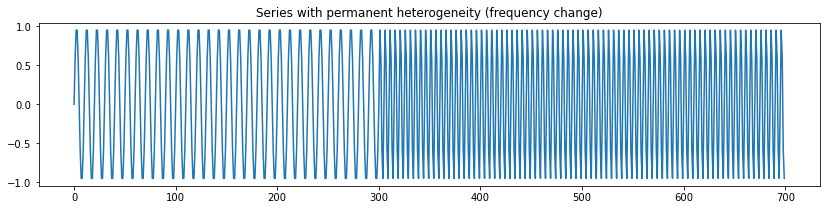

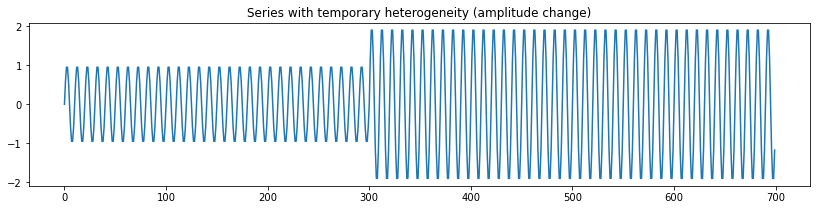

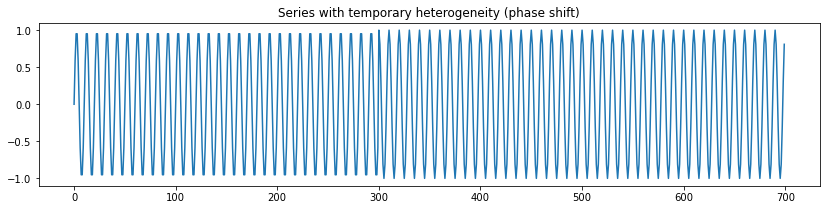

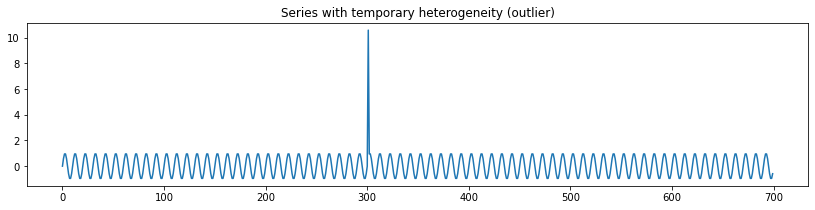

In [5]:
plotSeries(fPerm, 'Series with permanent heterogeneity (frequency change)', 14, 3)
plotSeries(fTemp, 'Series with temporary heterogeneity (amplitude change)', 14, 3)
plotSeries(fShifted, 'Series with temporary heterogeneity (phase shift)', 14, 3)
plotSeries(fOutlier, 'Series with temporary heterogeneity (outlier)', 14, 3)

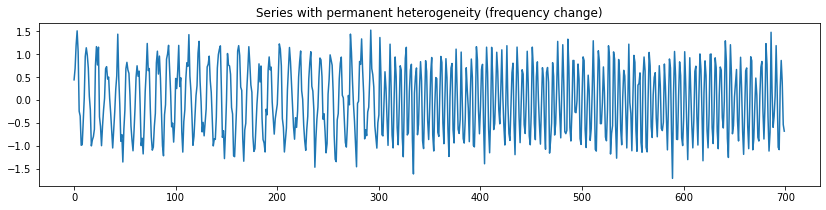

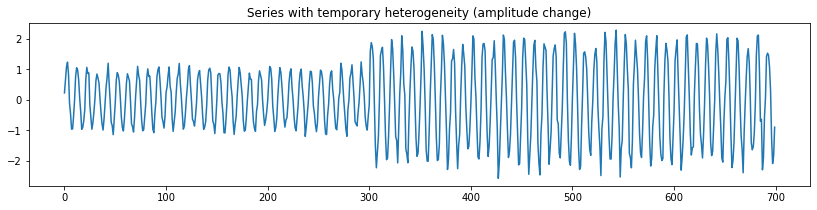

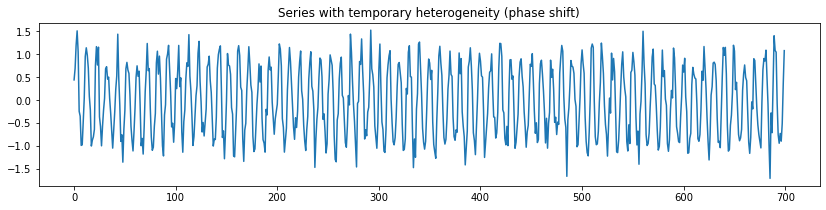

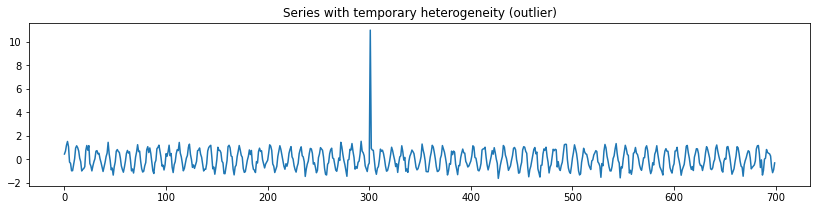

In [6]:
plotSeries(fPermNoise, 'Series with permanent heterogeneity (frequency change)', 14, 3)
plotSeries(fTempNoise, 'Series with temporary heterogeneity (amplitude change)', 14, 3)
plotSeries(fShiftedNoise, 'Series with temporary heterogeneity (phase shift)', 14, 3)
plotSeries(fOutlierNoise, 'Series with temporary heterogeneity (outlier)', 14, 3)

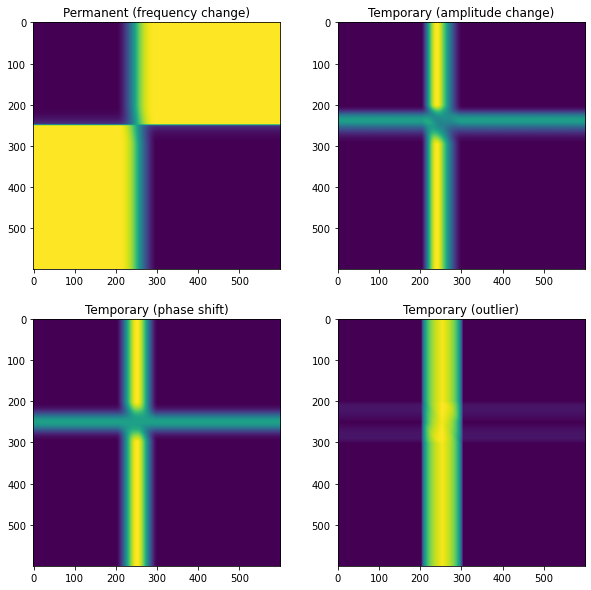

In [7]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10, 10))

ax1[0].imshow(hmPerm.hmatr)
ax1[0].set_title("Permanent (frequency change)")

ax1[1].imshow(hmTemp.hmatr)
ax1[1].set_title("Temporary (amplitude change)")

ax2[0].imshow(hmShifted.hmatr)
ax2[0].set_title("Temporary (phase shift)")

ax2[1].imshow(hmOutlier.hmatr)
ax2[1].set_title("Temporary (outlier)");

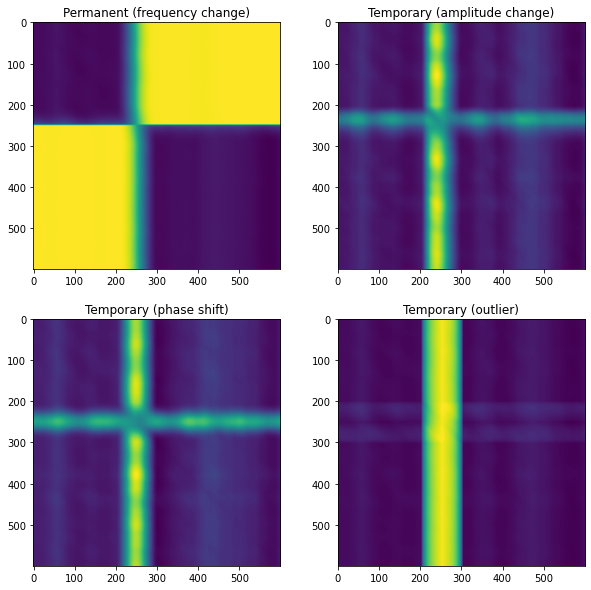

In [8]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10, 10))

ax1[0].imshow(hmPermNoise.hmatr)
ax1[0].set_title("Permanent (frequency change)")

ax1[1].imshow(hmTempNoise.hmatr)
ax1[1].set_title("Temporary (amplitude change)")

ax2[0].imshow(hmShiftedNoise.hmatr)
ax2[0].set_title("Temporary (phase shift)")

ax2[1].imshow(hmOutlierNoise.hmatr)
ax2[1].set_title("Temporary (outlier)")

plt.savefig("heterogeneity_types_noised.png")

Посмотрим на функции разладки

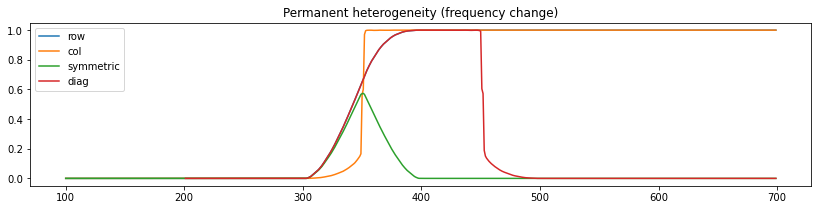

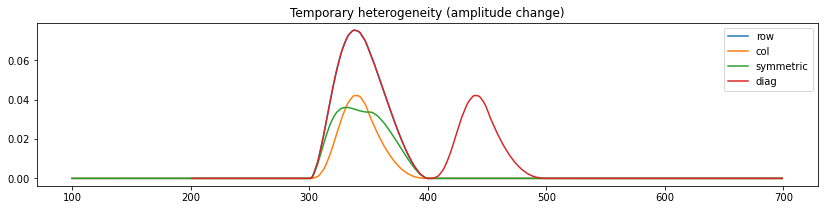

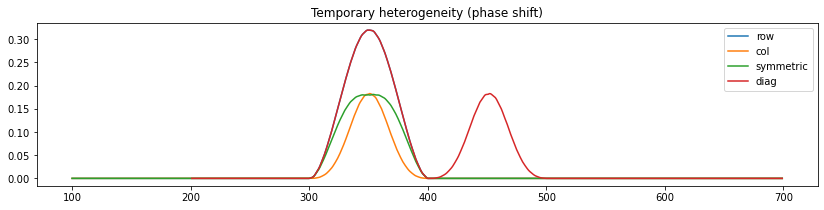

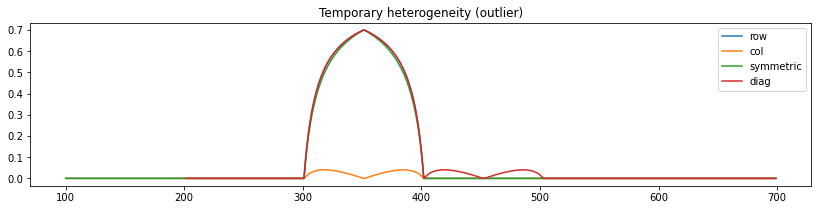

In [9]:
hmPerm.plotHeterFunc('Permanent heterogeneity (frequency change)', 14, 3)
hmTemp.plotHeterFunc('Temporary heterogeneity (amplitude change)', 14, 3)
hmShifted.plotHeterFunc('Temporary heterogeneity (phase shift)', 14, 3)
hmOutlier.plotHeterFunc('Temporary heterogeneity (outlier)', 14, 3)

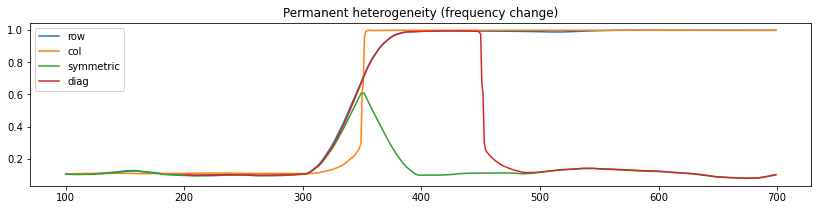

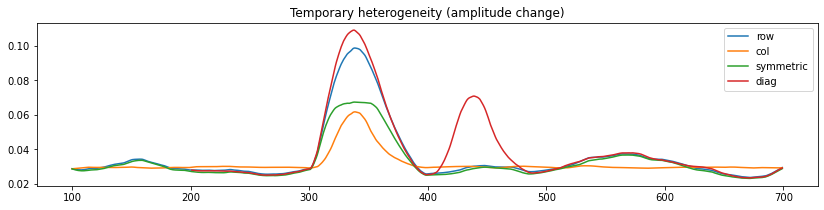

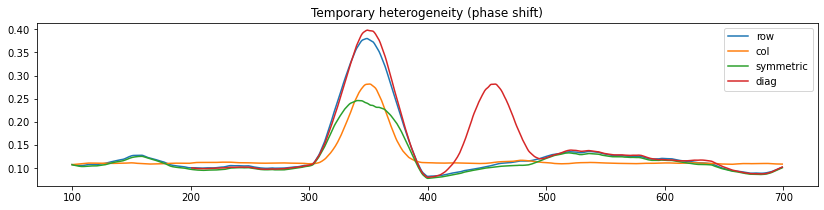

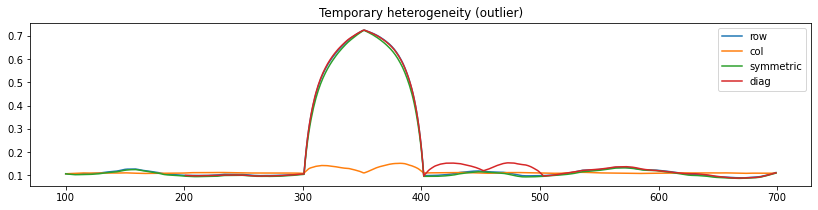

In [10]:
hmPermNoise.plotHeterFunc('Permanent heterogeneity (frequency change)', 14, 3)
hmTempNoise.plotHeterFunc('Temporary heterogeneity (amplitude change)', 14, 3)
hmShiftedNoise.plotHeterFunc('Temporary heterogeneity (phase shift)', 14, 3)
hmOutlierNoise.plotHeterFunc('Temporary heterogeneity (outlier)', 14, 3)

# Моделирование

Смоделируем случайный шум с дисперсией `noiseVariance` `200` раз на отрезке $[0, \cdots, Q-1]$ и посчитаем характеристики:
* Средний максимум;
* Средний 95 процентиль.

**Внимание**, моделирование достаточно долгое. На процессоре `Intel Core i5-7300HQ` моделирование на `200` итерациях `4`х вариантов, определенных выше заняло `30` минут.

In [15]:
?modellingNoiseStatistics

In [28]:
from utils.modelling import *

In [29]:
%%time
ds, summary_conf_ints = modellingNoiseStatistics(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    iterNum=200,
    N=N,
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    vareps = noiseVariance
)

{'Permanent': c_intervals(Row=array([[0.13323971, 0.13073953],
       [0.13351273, 0.13101476]]), Col=array([[0.11078758, 0.11034815],
       [0.11110321, 0.11066345]]), Sym=array([[0.13048405, 0.127839  ],
       [0.13075273, 0.12810862]]), Diag=array([[0.12598989, 0.12429052],
       [0.12630378, 0.12460181]])), 'Temporary': c_intervals(Row=array([[0.03609952, 0.0354876 ],
       [0.03618371, 0.03557159]]), Col=array([[0.03009661, 0.02997546],
       [0.0301944 , 0.0300731 ]]), Sym=array([[0.03528422, 0.03464248],
       [0.03536627, 0.03472448]]), Diag=array([[0.03447651, 0.03407389],
       [0.03455926, 0.03415734]])), 'Shifted': c_intervals(Row=array([[0.13195284, 0.12980263],
       [0.13223952, 0.13008298]]), Col=array([[0.11435351, 0.11392678],
       [0.11469687, 0.1142697 ]]), Sym=array([[0.12936201, 0.12700887],
       [0.12963982, 0.12728181]]), Diag=array([[0.12469517, 0.12334823],
       [0.12500379, 0.12365674]])), 'Outlier': c_intervals(Row=array([[0.13232955, 0.1302075

In [30]:
ds

,HeterType,StatType,row,col,sym,diag
0,Permanent,meanMax,0.133376,0.110945,0.130618,0.126147
1,Permanent,mean95Procentile,0.130877,0.110506,0.127974,0.124446
2,Temporary,meanMax,0.036142,0.030146,0.035325,0.034518
3,Temporary,mean95Procentile,0.035530,0.030024,0.034683,0.034116
4,Shifted,meanMax,0.132096,0.114525,0.129501,0.124849
5,Shifted,mean95Procentile,0.129943,0.114098,0.127145,0.123502
6,Outlier,meanMax,0.132471,0.110800,0.129573,0.127397
7,Outlier,mean95Procentile,0.130347,0.110320,0.127320,0.126176


In [31]:
ds.to_csv("tables/modelledStatistics.csv")

In [39]:
summary_conf_ints

{'Permanent': c_intervals(Row=array([[0.13323971, 0.13073953],
        [0.13351273, 0.13101476]]), Col=array([[0.11078758, 0.11034815],
        [0.11110321, 0.11066345]]), Sym=array([[0.13048405, 0.127839  ],
        [0.13075273, 0.12810862]]), Diag=array([[0.12598989, 0.12429052],
        [0.12630378, 0.12460181]])),
 'Temporary': c_intervals(Row=array([[0.03609952, 0.0354876 ],
        [0.03618371, 0.03557159]]), Col=array([[0.03009661, 0.02997546],
        [0.0301944 , 0.0300731 ]]), Sym=array([[0.03528422, 0.03464248],
        [0.03536627, 0.03472448]]), Diag=array([[0.03447651, 0.03407389],
        [0.03455926, 0.03415734]])),
 'Shifted': c_intervals(Row=array([[0.13195284, 0.12980263],
        [0.13223952, 0.13008298]]), Col=array([[0.11435351, 0.11392678],
        [0.11469687, 0.1142697 ]]), Sym=array([[0.12936201, 0.12700887],
        [0.12963982, 0.12728181]]), Diag=array([[0.12469517, 0.12334823],
        [0.12500379, 0.12365674]])),
 'Outlier': c_intervals(Row=array([[0.1323

In [32]:
summary_conf_ints['Permanent'].Row

array([[0.13323971, 0.13073953],
       [0.13351273, 0.13101476]])

## Результаты моделирования

In [10]:
resModelling = pd.read_excel('tables/results.xlsx', sheet_name='Modelling', engine='openpyxl')
resModelling.fillna(' ', inplace=True)
resModelling

,Permanent,row,col,sym,diag
0,meanMax,0.239104,0.20624,0.233901,0.218456
1,95 procentile,0.235221,0.205433,0.22974,0.216708
2,,,,,
3,Temporary,row,col,sym,diag
4,meanMax,0.068503,0.059271,0.066946,0.062382
5,95 procentile,0.067346,0.059055,0.065679,0.061582
6,,,,,
7,Shifted,row,col,sym,diag
8,meanMax,0.237175,0.204361,0.231907,0.216586
9,95 procentile,0.233583,0.203561,0.227927,0.214298


# Характеристики функций разладки

В данной серии экспериментов мы предполагаем что точка разладки известна. Тестирование каких-либо преодолений начинается с точки $Q$ (или с $Q+1$ элемента).

In [33]:
from utils.modelling import modellingSeriesStatistics
from utils.modelling import fixSeriesStatistics

Начнем с фиксирования характиристик на данных без шума.

In [12]:
?fixSeriesStatistics

Signature:
fixSeriesStatistics(
    dictSeries: dict,
    N: int,
    B: int,
    T: int,
    Q: int,
    L: int,
    r: int,
    method: str,
    destFile: str,
    modellingResultsPath: str,
    title: str,
)
Docstring:
Save results for series without noise
:param dict dictSeries: The dictionary where key is the type of series and value is a series. Example: { 'Permanent': [x_1, ..., x_N] }.
:param int N: The len of series.
:param int B: The len of base subseries.
:param int T: The len of test subseries.
:param int Q: The point of perturbation.
:param int L: The window len.
:param int r: Number of eigen vectors.
:param str method: SVD method.
:param str destFile: Name of the file for saving results.
:param str modellingResultsPath: Name of the file with modelling results.
:param str title: Sheet title where results will be stored.
File:      f:\users\ivank\documents\education\magistracy\researchwork\code\utils\modelling.py
Type:      function


In [23]:
%%time
fixSeriesStatistics(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    destFile='tables/results.xlsx',
    modellingResultsPath = 'tables/modelledStatistics.csv',
    title='withoutNoise'
)

Wall time: 7.89 s


Посмотрим что вышло.

In [12]:
fixedResultWithoutNoise = pd.read_excel('tables/results.xlsx', sheet_name='withoutNoise', engine='openpyxl')
fixedResultWithoutNoise.fillna(' ', inplace=True)
fixedResultWithoutNoise[:40]

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,Point of overcoming,328,328,,,Point of overcoming,350,350,,,Point of overcoming,329,329,,,Point of overcoming,327,327
2,X[Q],0,0,,,X[Q],0.0,0.0,,,X[Q],0,0,,,X[Q],0,0
3,X[Q+10],0.042795,0.042795,,,X[Q+10],0.002815,0.002815,,,X[Q+10],0.040179,0.040179,,,X[Q+10],0.042795,0.042795
4,X[Q+20],0.146766,0.146766,,,X[Q+20],0.013995,0.013995,,,X[Q+20],0.135379,0.135379,,,X[Q+20],0.146766,0.146766
5,X[Q+30],0.296227,0.296227,,,X[Q+30],0.038518,0.038518,,,X[Q+30],0.270609,0.270609,,,X[Q+30],0.296227,0.296227
6,,,,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


Моделируем данные с шумом используя результаты моделирования статистик шума ранее. Фиксируем средние значения.

In [15]:
?modellingSeriesStatistics

Signature:
modellingSeriesStatistics(
    dictSeries: dict,
    iterNum: int,
    N: int,
    B: int,
    T: int,
    Q: int,
    L: int,
    r: int,
    method: str,
    destFile: str,
    modellingResultsPath: str,
    title: str,
    vareps: float,
)
Docstring:
Modelling for series with noise
:param dict dictSeries: The dictionary where key is the type of series and value is a series. Example: { 'Permanent': [x_1, ..., x_N] }.
:param int iterNum: Number of iterations for modelling.
:param int N: The len of series.
:param int B: The len of base subseries.
:param int T: The len of test subseries.
:param int Q: The point of perturbation.
:param int L: The window len.
:param int r: Number of eigen vectors.
:param str method: SVD method.
:param str destFile: Name of the file for saving results.
:param str modellingResultsPath: Name of the file with modelling results.
:param str title: Sheet title where results will be stored.
:param float vareps: Variance of the noise.
File:      f:\user

In [45]:
from utils.coop_modelling import modelling_series_statistics

In [47]:
%%time
confidence_intervals = \
    modelling_series_statistics(
        dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
        iterNum=200,
        N=N,
        B=B,
        T=T_,
        Q=Q,
        L=L,
        r=r,
        method=method,
        destFile='tables/correct_results_1.xlsx',
        title='withNoise',
        vareps=noiseVariance
    )

fixedResult = pd.read_excel('tables/results.xlsx', sheet_name='withNoise', engine='openpyxl', usecols=range(18))
fixedResult.fillna(' ', inplace=True)
fixedResult[:40]

Wall time: 28min 53s


,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,Num Points of overcoming,1,1,,,Num Points of overcoming,1,1,,,Num Points of overcoming,1,1,,,Num Points of overcoming,1,1
2,detected Q,315,315,,,detected Q,319,319,,,detected Q,317,317,,,detected Q,317,317
3,X[detected Q],0.368252,0.368252,,,X[detected Q],0.336579,0.336579,,,X[detected Q],0.35414,0.35414,,,X[detected Q],0.370218,0.370218
4,X[Q],0.31682,0.31682,,,X[Q],0.311567,0.311567,,,X[Q],0.305037,0.305037,,,X[Q],0.310245,0.310245
5,X[Q+10],0.345466,0.345466,,,X[Q+10],0.320318,0.320318,,,X[Q+10],0.32603,0.32603,,,X[Q+10],0.333423,0.333423
6,X[Q+20],0.41811,0.41811,,,X[Q+20],0.342992,0.342992,,,X[Q+20],0.381228,0.381228,,,X[Q+20],0.40624,0.40624
7,X[Q+30],0.524997,0.524997,,,X[Q+30],0.374984,0.374984,,,X[Q+30],0.471484,0.471484,,,X[Q+30],0.5092,0.5092
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


In [48]:
confidence_intervals

{'Permanent': {'mean_max': {'Row': {'overc_p': array([316.24846626, 316.41153374]),
    'overc_p_val': array([0.39296993, 0.39380899])},
   'Col': {'overc_p': array([321.16587968, 321.35412032]),
    'overc_p_val': array([0.33358991, 0.33456018])},
   'Sym': {'overc_p': array([317.03489061, 317.20510939]),
    'overc_p_val': array([0.38475572, 0.38559706])},
   'Diag': {'overc_p': array([313.00824818, 313.17175182]),
    'overc_p_val': array([0.37275544, 0.37364562])}},
  '95': {'Row': {'overc_p': array([316.24846626, 316.41153374]),
    'overc_p_val': array([0.39296993, 0.39380899])},
   'Col': {'overc_p': array([321.16587968, 321.35412032]),
    'overc_p_val': array([0.33358991, 0.33456018])},
   'Sym': {'overc_p': array([317.03489061, 317.20510939]),
    'overc_p_val': array([0.38475572, 0.38559706])},
   'Diag': {'overc_p': array([313.00824818, 313.17175182]),
    'overc_p_val': array([0.37275544, 0.37364562])}}},
 'Temporary': {'mean_max': {'Row': {'overc_p': array([310.99648412, 

In [43]:
%%time
modelling_series_conf_ints = modellingSeriesStatistics(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    iterNum=200,
    N=N,
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    destFile='tables/correct_results.xlsx',
    modellingResultsPath = 'tables/modelledStatistics.csv',
    title='withNoise',
    vareps=noiseVariance
)

Wall time: 28min 51s


In [44]:
modelling_series_conf_ints

{'Permanent': {'mean_max': {'Row': {'overc_p': array([309.08654312, 309.15345688]),
    'overc_p_val': array([0.13693871, 0.1369995 ])},
   'Col': {'overc_p': array([313.34905911, 313.57094089]),
    'overc_p_val': array([0.11663999, 0.11682556])},
   'Sym': {'overc_p': array([309.42059164, 309.48940836]),
    'overc_p_val': array([0.13404694, 0.13410369])},
   'Diag': {'overc_p': array([307.74011157, 307.80988843]),
    'overc_p_val': array([0.12996132, 0.13004612])}},
  '95': {'Row': {'overc_p': array([308.61067408, 308.67932592]),
    'overc_p_val': array([0.13457902, 0.13464467])},
   'Col': {'overc_p': array([313.17446438, 313.39553562]),
    'overc_p_val': array([0.11643504, 0.11662274])},
   'Sym': {'overc_p': array([308.90509503, 308.97490497]),
    'overc_p_val': array([0.1314279 , 0.13149076])},
   'Diag': {'overc_p': array([307.40980654, 307.48019346]),
    'overc_p_val': array([0.12839029, 0.12848254])}}},
 'Temporary': {'mean_max': {'Row': {'overc_p': array([306.85640908, 

Посмотрим на результаты данных с шумом (на которых и проводилось моделирование).

In [40]:
fixedResultWithNoise = pd.read_excel('tables/correct_results.xlsx', sheet_name='withNoise', engine='openpyxl')
fixedResultWithNoise.fillna(' ', inplace=True)
fixedResultWithNoise[:50]

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,Num Points of overcoming,200,200,,,Num Points of overcoming,200,200,,,Num Points of overcoming,200,200,,,Num Points of overcoming,200,200
2,detected Q,309,308,,,detected Q,313,313,,,detected Q,309,309,,,detected Q,308,307
3,X[detected Q],0.137097,0.134624,,,X[detected Q],0.117255,0.116957,,,X[detected Q],0.133955,0.131581,,,X[detected Q],0.130298,0.128784
4,X[Q],0.110038,0.110038,,,X[Q],0.108008,0.108008,,,X[Q],0.107263,0.107263,,,X[Q],0.110174,0.110174
5,X[Q+10],0.147911,0.147911,,,X[Q+10],0.110535,0.110535,,,X[Q+10],0.142919,0.142919,,,X[Q+10],0.14806,0.14806
6,X[Q+20],0.239488,0.239488,,,X[Q+20],0.120881,0.120881,,,X[Q+20],0.226668,0.226668,,,X[Q+20],0.239523,0.239523
7,X[Q+30],0.371239,0.371239,,,X[Q+30],0.143836,0.143836,,,X[Q+30],0.345391,0.345391,,,X[Q+30],0.371232,0.371232
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


Как мы отмечали ранее, для фазового сдвига и временной разладки результаты не несут какой-либо ценности.

В остальных же случаях можно наблюдать какая функция разладки начинает возрастать раньше и по выведенным $4$ точкам можно сравнить скорость возрастания. 

Блоки с пустыми полями соответствуют ситуации, когда разладка не найдена.